In [1]:
import pandas as pd
import os, sys
import numpy as np
os.environ["KERAS_BACKEND"] = 'tensorflow'
from keras.utils import np_utils
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.externals import joblib
pd.options.mode.chained_assignment = None  # default='warn'
import re
from floor.data.dataset_loader import TestData


import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from peakdetect import peakdetect
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
import math
from keras.models import load_model
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


---
# Load models

In [3]:
random_forest = joblib.load('../best_model_weights/random_forest/weights/random_forest_final_1_0_trial_144.pkl')

In [4]:
svm = joblib.load('../best_model_weights/svm/weights/svm_final_1_0_trial_85.pkl')

In [5]:
log_reg = joblib.load('../best_model_weights/logistic_regression/weights/logistic_regression_final_1_0_trial_179.pkl')

In [9]:
hmm = joblib.load('../best_model_weights/hmm/weights/hmm_final_1_0_trial_59.pkl')

In [7]:
nn = load_model('../best_model_weights/fc_nn/weights/fc_nn_final_1_18_trial_18.h5')

In [14]:
lstm = load_model('../best_model_weights/lstm/weights/lstm_final_1_188_trial_188.h5')
lstm_window_size = 3

/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [501]:
use_model = 'lstm' # 'lstm', 'nn', 'lg', 'svm', 'rf', 'hmm'

# True = m will be based on each building. False = m will be 4.02 (mean from bldgs dataset)
use_building_based_m_val = False

plot_classifications = False

---
# Load dataset

Load data from all training runs in array of pandas

In [481]:
def load_data(exp_name='_', data_path='../data/floor_prediction_test_data/data'):
    frames = []
    frames_names = []
    for file_name in os.listdir(data_path):
        if 'csv' in file_name and exp_name in file_name:
            in_path = '%s/%s' % (data_path, file_name)
            df = pd.read_csv(in_path)
            df = df.fillna(0)
            frames.append(df)
            frames_names.append(file_name)

    # add weather data
    for df in frames:
        df['weather_pressure'] = [100] * len(df)
    
    # run predictions on each frame
    rf_frames, rf_accuracies = predict_dfs_sklearn_model(random_forest, frames, 'RF')
    svm_frames, svm_accuracies = predict_dfs_sklearn_model(svm, frames, 'SVM')
    lg_frames, lg_accuracies = predict_dfs_sklearn_model(log_reg, frames, 'LG')
    hmm_frames, hmm_accuracies = predict_dfs_sklearn_hmm(hmm, frames, 'HMM')
    nn_frames, accuracies = predict_dfs_nn(frames)
    lstm_frames, accuracies = predict_dfs_lstm(frames)

    result_frames = None
    if use_model == 'rf':
        result_frames = rf_frames
    if use_model == 'svm':
        result_frames = svm_frames
    if use_model == 'lg':
        result_frames = lg_frames
    if use_model == 'hmm':
        result_frames = hmm_frames
    if use_model == 'nn':
        result_frames = nn_frames
    if use_model == 'lstm':
        result_frames = lstm_frames
        
    return result_frames, frames_names


def filter_exps(exps, names, allowed):
    allowed = []
    allowed_names = []
    for n in names:
        if n in allowed:
            allowed.append(exps)
            allowed_names.append(names)
    return allowed, allowed_names 

---
# Extract Features
Define fx to do a window around the point
This means that X will become 3 points concatenated as a feature vector

In [450]:

def create_window_features_lstm(X, Y, window_length = lstm_window_size):

    # make odd so we can take half on left, half on right of point

    new_X = []
    new_Y = np.zeros((len(X) - window_length, 1))
    arr_i = 0
    side_size = int((window_length - 1) /2)
    for i in range(side_size, len(X)):
        i_start = i - side_size
        i_end = i + side_size + 1
        y_i = i
        dps = X[i_start:i_end, :]
        new_x = dps        
        new_y = Y[y_i]
        if i_end >= len(X):
            break
        new_X.append(new_x)
        new_Y[arr_i] = new_y
        arr_i += 1
    
    new_X = np.asarray(new_X)
    return new_X, new_Y


def create_window_features(X, Y, window_length = 3):

    # make odd so we can take half on left, half on right of point

    new_X = np.zeros((len(X) - window_length, window_length * len(X[0])))
    new_Y = np.zeros((len(X) - window_length, 1))
    arr_i = 0
    side_size = int((window_length - 1) /2)
    for i in range(side_size, len(X)):
        i_start = i - side_size
        i_end = i + side_size + 1
        y_i = i
        dps = X[i_start:i_end, :]
        new_x = dps.flatten()
        new_y = Y[y_i]
        if i_end >= len(X):
            break
        new_X[arr_i] = new_x
        new_Y[arr_i] = new_y
        arr_i += 1

    return new_X, new_Y

Pick out the features we care about

In [451]:
def extract_features(df, features, y_label):
    x_df = df[features]
    y_df = df[[y_label]]
    
    return x_df, y_df

---
# Format data

In [452]:
def convert_test_data_to_nn_format(X_train, Y_train):
    nb_classes = 2
    X_train = X_train.astype('float32')

    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(Y_train.flatten(), nb_classes)
    return X_train, Y_train

In [453]:
def create_test_data(df, X_features, Y_label, nn_format=False, hmm_format=False):
    x_df, y_df = extract_features(df, X_features, Y_label)

    X = x_df.as_matrix()
    Y = y_df.as_matrix()
    
    if not hmm_format:
        X, Y = create_window_features(X, Y)
    
    if nn_format:
        X, Y = convert_test_data_to_nn_format(X, Y)
    return X, Y

In [454]:
def create_lstm_test_data(df, X_features, Y_label):
    x_df, y_df = extract_features(df, X_features, Y_label)

    X = x_df.as_matrix()
    Y = y_df.as_matrix()

    X, Y = create_window_features_lstm(X, Y)
    return X, Y

---
# Build predict FX helpers

Neural networks predict helpers

In [455]:
def predict_nn(nn, df, X, Y, window_length=3):
    df_with_window = df[0:-window_length]
    preds = nn.predict(X)
    results = np.argmax(preds, axis=1).reshape(len(preds), 1)
    
    # save to new df
    df_with_window['indoors_prediction'] = results
    
    # print acc stats
    accuracy = nn.evaluate(X, Y, verbose=0)[1]
    
    return df_with_window, accuracy

def predict_lstm(nn, df, X, Y, window_length=lstm_window_size):

    df_with_window = df[0:-window_length]
    preds = nn.predict(X)
    results = np.argmax(preds, axis=1).reshape(len(preds), 1)
    
    # save to new df
    df_with_window['indoors_prediction'] = results
    
    # print acc stats
    accuracy = nn.evaluate(X, Y, verbose=0)[1]
    
    return df_with_window, accuracy

In [456]:
def predict_dfs_lstm(frames):
    accuracies = []
    predicted = []
    for df in frames:
        X, Y = create_lstm_test_data(df, X_features =
                            ['gps_vertical_accuracy', 
                             'gps_horizontal_accuracy', 
                             'gps_speed', 
                             'rssi_strength', 
                             'magnet_total'], 
                            Y_label='indoors')
        df, accuracy = predict_lstm(lstm, df, X, Y)
        predicted.append(df)
        accuracies.append(float("{0:.2f}".format(accuracy)))
    avg_acc = np.mean(accuracies)
    print('avg acc NN: ', float("{0:.3f}".format(avg_acc)))
    return predicted, accuracies

def predict_dfs_nn(frames):
    accuracies = []
    predicted = []
    for df in frames:
        X, Y = create_test_data(df, X_features =
                            ['gps_vertical_accuracy', 
                             'gps_horizontal_accuracy', 
                             'gps_speed', 
                             'rssi_strength', 
                             'magnet_total'], 
                            Y_label='indoors', nn_format=True)
        df, accuracy = predict_nn(nn, df, X, Y)
        predicted.append(df)
        accuracies.append(float("{0:.2f}".format(accuracy)))
    avg_acc = np.mean(accuracies)
    print('avg acc NN: ', float("{0:.3f}".format(avg_acc)))
    return predicted, accuracies


Random forest predict helpers

In [457]:
def predict_model(model, df, X, Y, window_length=3):
    df_with_window = df[0:-window_length]
    preds = model.predict(X)
    results = preds.reshape(len(X), 1)
    
    # save to new df
    df_with_window['indoors_prediction'] = results
    
    # print acc stats
    accuracy = df_with_window[df_with_window.indoors == df_with_window.indoors_prediction].count()['indoors'] / float(len(df_with_window))
    
    return df_with_window, accuracy

def predict_model_hmm(model, df, X, Y):
    df_with_window = df

    Y_hat = model.predict(X)
    results = Y_hat.reshape(len(X), 1)
    
    # save to new df
    df_with_window['indoors_prediction'] = results
    
    # print acc stats

    accuracy = np.equal(Y_hat.flatten(), Y.flatten()).sum() / float(Y.shape[0])
    
    return df_with_window, accuracy

In [458]:
def predict_dfs_sklearn_hmm(model, frames, model_name):
    accuracies = []
    predicted = []
    for df in frames:
        X, Y = create_test_data(df, X_features =
                            ['gps_vertical_accuracy', 
                             'gps_horizontal_accuracy', 
                             'gps_speed', 
                             'rssi_strength', 
                             'magnet_total'], 
                            Y_label='indoors', nn_format=False, hmm_format=True)
        df, accuracy = predict_model_hmm(model, df, X, Y)
        predicted.append(df)
        accuracies.append(float("{0:.2f}".format(accuracy)))
    avg_acc = np.mean(accuracies)
    print('avg acc {}: '.format(model_name), float("{0:.3f}".format(avg_acc)))
    return predicted, accuracies

In [459]:
def predict_dfs_sklearn_model(model, frames, model_name):
    accuracies = []
    predicted = []
    for df in frames:
        X, Y = create_test_data(df, X_features =
                            ['gps_vertical_accuracy', 
                             'gps_horizontal_accuracy', 
                             'gps_speed', 
                             'rssi_strength', 
                             'magnet_total'], 
                            Y_label='indoors', nn_format=False)
        df, accuracy = predict_model(model, df, X, Y)
        predicted.append(df)
        accuracies.append(float("{0:.2f}".format(accuracy)))
    avg_acc = np.mean(accuracies)
    print('avg acc {}: '.format(model_name), float("{0:.3f}".format(avg_acc)))
    return predicted, accuracies 

In [460]:
def ground_truth_floor(test_name):
    real_floor = test_name.split('_')
    print(real_floor)
    real_floor_start = int(real_floor[2])
    real_floor_end = int(real_floor[-1].split('.')[0])
    floor_delta = real_floor_end - real_floor_start
    #floor_delta = floor_delta + 1 if real_floor_start < real_floor_end else floor_delta - 1
    return floor_delta, real_floor_start, real_floor_end

---
# Find I/O intervals
Find in/out intervals by looking at the classification results. Use a rolling window that checks on cosine distance to find the best matches

In [461]:
def find_io_intervals(dfa, min_similarity):
    # ---------------
    # define IO vector mask
    target_vector_in_out = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
    target_vector_in_out = np.add(target_vector_in_out, 1).tolist()
    target_vector_out_in = target_vector_in_out[::-1]
    window_size = len(target_vector_in_out)

    preds = dfa['indoors_prediction'].tolist()
    # ---------------
    # find matches
    matches = []
    for i in range(0, len(preds) - window_size):
        vec = preds[i: i + window_size]
        vec = np.add(vec, 1)
        
        dist_a = distance.jaccard(target_vector_in_out, vec)
        dist_b = distance.jaccard(vec, target_vector_out_in)
        
        if dist_a >= min_similarity:
            matches.append(i)

        elif dist_b >= min_similarity:
            matches.append(i)

    sorted(matches)
    
    # ---------------
    # Group matches
    merged = [(matches[0], matches[0] + 2)]
    for start in matches[1:]:
        end = start+2

        merged_start, merged_end = merged[-1]

        if (start <= merged_end):
            merged[-1] = (merged_start, max(merged_end, end))

        else:
            merged.append((start, end))
        
    # --------------
    # FIND PEAKS
    #print('Merged interval groups:')
    #print(merged)
    stack = []
    for x, y in merged:
        avg = np.mean([x,y])
        stack.append(avg)

    #print('\nFinal Transition locations (ith datapoint):')
    #print(stack)
    peaks_detected_by_classifier = stack
    return peaks_detected_by_classifier

In [462]:
def find_io_intervals_cosine(dfa, min_similarity):
    # ---------------
    # define IO vector mask
    target_vector_in_out = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
    target_vector_in_out = np.add(target_vector_in_out, 1).tolist()
    window_size = len(target_vector_in_out)
    target_vector_out_in = target_vector_in_out[::-1]
    target_vector_in_out = np.asarray(target_vector_in_out).reshape(1,-1)
    target_vector_out_in = np.asarray(target_vector_out_in).reshape(1,-1)
    

    preds = dfa['indoors_prediction'].tolist()
    # ---------------
    # find matches
    matches = []
    for i in range(0, len(preds) - window_size):
        vec = np.asarray(preds[i: i + window_size]).reshape(1,-1)
        vec = np.add(vec, 1)

        dist_a = cosine_similarity(target_vector_in_out, vec)
        dist_b = cosine_similarity(vec, target_vector_out_in)
        
        if dist_a >= min_similarity:
            matches.append(i)

        elif dist_b >= min_similarity:
            matches.append(i)

    sorted(matches)
    
    # ---------------
    # Group matches
    merged = [(matches[0], matches[0] + 2)]
    for start in matches[1:]:
        end = start+2

        merged_start, merged_end = merged[-1]

        if (start <= merged_end):
            merged[-1] = (merged_start, max(merged_end, end))

        else:
            merged.append((start, end))
        
    # --------------
    # FIND PEAKS
    #print('Merged interval groups:')
    #print(merged)
    stack = []
    for x, y in merged:
        avg = np.mean([x,y])
        stack.append(avg)

    #print('\nFinal Transition locations (ith datapoint):')
    #print(stack)
    peaks_detected_by_classifier = stack
    return peaks_detected_by_classifier

---
## Find floor location using baro pressure

Plot barometric timeseries

---
## Calculate floor level change from last IN/OUT transition

Pull the datapoint at the peak index

In [463]:
def get_last_transition_dp(dfa, peaks_detected_by_classifier):
    last_transition_index = int(peaks_detected_by_classifier[-1])
    dp = dfa.iloc[[last_transition_index]]
    return dp, last_transition_index

Pull the datapoint at the last known index (where user is)

---
### Determine peak at min/max if delta is +-
We look at a window before and after the last transition point and average these points to determine the direction of change. Then we'll find the max if the direction is negative or the min if the direction is positive

In [464]:
def find_optimal_transition_point(dfa, last_transition_index):
    num_points_around_transition = 10
    lookback_window = 20
    #print('last transition idx: ', last_transition_index)
    
    before = dfa[last_transition_index - num_points_around_transition : last_transition_index]
    after = dfa[last_transition_index : last_transition_index + num_points_around_transition]
    before_mean_pressure = np.mean(before.baro_pressure)
    after_mean_pressure = np.mean(after.baro_pressure)
    direction_change = "pos" if before_mean_pressure < after_mean_pressure else "neg"

    if direction_change is "pos":
        optimal_point = np.argmin(dfa.baro_pressure[last_transition_index - lookback_window : last_transition_index]) 
    else:
        optimal_point = np.argmax(dfa.baro_pressure[last_transition_index - lookback_window : last_transition_index]) 

    #print('optimal transition idx: ', optimal_point)
    dp = dfa.iloc[[optimal_point]]
    
    return dp

---
Calculate current floor from rel altitude change

In [465]:
def predict_current_floor(dp, last_dp, floor_height_meters):
    # pressure readings at time of last transition
    transition_device_pressure = dp.baro_pressure.values[0]
    weather_pressure_at_transition = dp.weather_pressure.values[0]

    # pressure readings at current point
    current_device_pressure = last_dp.baro_pressure.values[0]
    current_weather_pressure = last_dp.weather_pressure.values[0]

    # calculate weather pressure delta
    weather_pressure_delta = current_weather_pressure - weather_pressure_at_transition

    # calculate device pressure delta
    weather_adjusted_start_device_pressure = transition_device_pressure + weather_pressure_delta

    # this is the difference between pressures formula
    # the answer is in meters
    total_meter_change = 44330 * (1 - (current_device_pressure/weather_adjusted_start_device_pressure)**(1/5.255))

    # floor detection rule
    floor_delta = int(total_meter_change / floor_height_meters)
    if floor_delta >= 0:
        current_floor = 1 + floor_delta
    else:
        current_floor = floor_delta
    
    return current_floor, total_meter_change, floor_delta

In [466]:
def calculate_total_meter_change(dp, last_dp):
    # pressure readings at time of last transition
    transition_device_pressure = dp.baro_pressure.values[0]
    weather_pressure_at_transition = dp.weather_pressure.values[0]

    # pressure readings at current point
    current_device_pressure = last_dp.baro_pressure.values[0]
    current_weather_pressure = last_dp.weather_pressure.values[0]

    # calculate weather pressure delta
    weather_pressure_delta = current_weather_pressure - weather_pressure_at_transition

    # calculate device pressure delta
    weather_adjusted_start_device_pressure = transition_device_pressure + weather_pressure_delta

    # this is the difference between pressures formula
    # the answer is in meters
    total_meter_change = 44330 * (1 - (current_device_pressure/weather_adjusted_start_device_pressure)**(1/5.255))

    return total_meter_change

---
Determine if outside or inside right now

In [467]:
def get_io_status(dfa, last_transition_index):
    after_last_transition_points = dfa[last_transition_index : ]
    indoor_preds = after_last_transition_points.indoors_prediction
    pcnt_inside = indoor_preds[indoor_preds == 1].sum() / float(len(indoor_preds))
    inside_status = 'indoors' if pcnt_inside > 0.5 else 'outdoors'
    return inside_status

In [468]:
# colors
non_primary_alpha = 0.3
C_1 = (0,0,0,non_primary_alpha)
C_2 = (1.0, 0.0, 0.0, non_primary_alpha)
C_3 = (0.2,0.59,0.85,non_primary_alpha)
C_4 = (0.6,0.35,0.71,non_primary_alpha)
C_5 = (0.9,0.5,0.13,non_primary_alpha)
C_primary = 'blue'
C_primary_2 = 'orange'
C_secondary = (0, 0, 1, 0.3)

In [469]:
def plot_baro(dfa, dataset_name):
    # -----------
    # predicted in out
    # Plot the indoor vs outdoor true state
    plt.ylabel('pressure reading')
    plt.plot(dfa['baro_pressure'].tolist(), label='Baro pressure', color=C_primary)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.ylim((-1,2))
    savefig('./images/{}_baro_pressure.png'.format(dataset_name), bbox_inches='tight')
    plt.show()


    # -----------
    # predicted in out
    # Plot the indoor vs outdoor true state
    plt.ylabel('Rel altitude reading')
    plt.plot(dfa['baro_relative_altitude'].tolist(), label='Relative altitude', color=C_primary)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim((-1,2))
    savefig('./images/{}_relative_altitude.png'.format(dataset_name), bbox_inches='tight')
    plt.show()

In [470]:
def find_true_transition(dfa):
    for i, row in dfa.iterrows():
        if row.indoors == 1:
            return i

In [471]:
def plot_classification(dfa, peaks_detected_by_classifier, optimal_trans_dp, dataset_name):
    # -----------------------
    # FEAUTRES GRAPH
    # vertical accuracy graph
    
    hor_accu = (dfa['gps_horizontal_accuracy'] / max(dfa['gps_horizontal_accuracy']) ).tolist()
    ver_accu = (dfa['gps_vertical_accuracy'] / max(dfa['gps_vertical_accuracy']) ).tolist()
    magnet = (dfa['magnet_total'] / max(dfa['magnet_total']) ).tolist()
    rssi = (dfa['rssi_strength'] / max(dfa['rssi_strength']) ).tolist()
    gps_speed = (dfa['gps_speed'] / max(dfa['gps_speed']) ).tolist()
    plt.plot(hor_accu, label='GPS Hor Accuracy', color=C_1)
    plt.plot(ver_accu, label='GPS Vert Accuracy', color=C_2)
    plt.plot(magnet, label='Magnetometer strength', color=C_3)
    plt.plot(rssi, label='Cell RSSI strength', color=C_4)
    plt.plot(gps_speed, label='GPS Speed', color=C_5)
    plt.ylabel('Transitions via NNIO Classifier')


    # These are peaks discovered via the classifier
    # plot peaks via classifier method
    for i, peak in enumerate(peaks_detected_by_classifier):
        label = 'InOut transition via NNIO' if i == 0 else None
        plt.axvline(x=peak, color=C_secondary, label=label, linestyle='--')
    
    # plot the optimal transition point
    plt.axvline(x=optimal_trans_dp, color=C_primary, label='Estimated InOut transition', linestyle='--')
    
    # find true transition
    true_transition = find_true_transition(dfa)
    plt.axvline(x=true_transition, color=C_primary_2, label='True transition', linestyle='-')

    plt.legend(loc=1)
    plt.ylim((-1,2))
    savefig('./images/{}_features.png'.format(dataset_name), bbox_inches='tight')
    plt.show()

    # ----------------------------
    # IN/OUT GRAPH
    # true in/out
    plt.subplot(212)
    plt.ylabel('1=in 0=out')
    plt.plot(dfa['indoors'].tolist(), label='In/Out Truth')
    plt.legend(loc=1)
    plt.subplot(212)

    # predicted in out
    plt.ylabel('1=in 0=out')
    plt.plot(dfa['indoors_prediction'].tolist(), label='In/Out prediction NNIO')
    plt.legend(loc=0)
    plt.ylim((-1,3))
    savefig('./images/{}_IO_class.png'.format(dataset_name), bbox_inches='tight')
    plt.show()

---
## TEST CLASSIFICATION
 ---

In [472]:
def run_flr_find(frames, frames_names):
    meter_changes = []
    for i, dfa in enumerate(frames):
        dfa = frames[i]
        test_name = frames_names[i]

        # detect peaks
        # peaks_detected_by_classifier = find_io_intervals_cosine(dfa, min_similarity=0.7) #0.1
        peaks_detected_by_classifier = find_io_intervals(dfa, min_similarity=0.4) #0.1


        # find last point a transition happened
        last_transition_dp, last_transition_index = get_last_transition_dp(dfa, peaks_detected_by_classifier)

        # last dp of user loc
        last_dp = dfa.iloc[[-1]]

        # find point where the optimal transition happened
        # this is the lowest point around a transition window
        optimal_trans_dp = find_optimal_transition_point(dfa, last_transition_index)

        # make floor pred
        total_meter_change = calculate_total_meter_change(optimal_trans_dp, last_dp)

        meter_changes.append(abs(total_meter_change))
        
        
    df = pd.DataFrame(meter_changes)
    df.to_csv('/Users/waf/Desktop/meters.csv')
    return df
    
focus_exp_name = ''
frames, frames_names = load_data(focus_exp_name)                      
#print('num experiments: ', len(frames))

meters = run_flr_find(frames,frames_names).values.flatten()
#print(meters)



avg acc RF:  0.843
avg acc SVM:  0.874
avg acc LG:  0.663


/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/s

avg acc HMM:  0.618
avg acc NN:  0.901
avg acc NN:  0.901


In [502]:
def run(frames, frames_names,  floor_height_meters=3.55, heights=None, plot=plot_classifications):
    preds = []
    flr_heights = []
    for i, dfa in enumerate(frames):
        dfa = frames[i]
        test_name = frames_names[i]
        if heights is not None:
            test_start = test_name.split('_')[0]
            floor_height_meters = heights[test_start]
        
        # detect peaks
        # peaks_detected_by_classifier = find_io_intervals_cosine(dfa, min_similarity=0.7) #0.1
        peaks_detected_by_classifier = find_io_intervals(dfa, min_similarity=0.4) #0.1


        # find last point a transition happened
        last_transition_dp, last_transition_index = get_last_transition_dp(dfa, peaks_detected_by_classifier)

        # last dp of user loc
        last_dp = dfa.iloc[[-1]]

        # find point where the optimal transition happened
        # this is the lowest point around a transition window
        optimal_trans_dp = find_optimal_transition_point(dfa, last_transition_index)

        # make floor pred
        current_floor, total_meter_change, predicted_floor_delta = predict_current_floor(optimal_trans_dp, last_dp, floor_height_meters=floor_height_meters)

        # determine if indoors or not
        io_status = get_io_status(dfa, last_transition_index)

        # print real floor info
        floor_delta, real_floor_start, real_floor_end = ground_truth_floor(test_name)
        flr_heights.append(total_meter_change / floor_delta)
        
        preds.append({'pred_delta': predicted_floor_delta, 'predicted': current_floor, 'real_delta': floor_delta, 'name': test_name, 'test_start': real_floor_start, 'test_end': real_floor_end})

        # plot
        dataset_name = test_name.split('.')[0]
        if plot:
            plot_classification(dfa, peaks_detected_by_classifier, optimal_trans_dp.index, dataset_name)
            plot_baro(dfa, dataset_name)
        
    #print(np.mean(flr_heights))
    df = pd.DataFrame(preds)
    df.to_csv('/Users/waf/Desktop/predictions.csv')
    return df, flr_heights
    
focus_exp_name = ''
frames, frames_names = load_data(focus_exp_name)                      
print('num experiments: ', len(frames))

if use_building_based_m_val:
    results, flr_heights = run(frames,frames_names, heights={'gsb': 3.8, 'mudd': 3.4, 'noco': 4.2, 'ssw': 3.9, 'rock': 3.8})
else:
    results, flr_heights = run(frames,frames_names, 4.02)
print(results)

avg acc RF:  0.843
avg acc SVM:  0.874
avg acc LG:  0.663


/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/s

avg acc HMM:  0.618
avg acc NN:  0.901
avg acc NN:  0.901
num experiments:  63
['gsb', 'a', '1', '3.csv']
['gsb', 'b', '1', '8.csv']
['gsb', 'c', '1', '3.csv']
['gsb', 'e', '1', '8.csv']
['gsb', 'f', '1', '8.csv']
['gsb', 'g', '1', '8.csv']
['gsb', 'h', '1', '3.csv']
['gsb', 'i', '1', '3.csv']
['gsb', 'j', '1', '3.csv']
['gsb', 'k', '1', '3.csv']
['gsb', 'l', '1', '3.csv']
['gsb', 'm', '1', '3.csv']
['gsb', 'n', '1', '3.csv']
['gsb', 'o', '1', '3.csv']
['mudd', 'a', '4', '11.csv']
['mudd', 'b', '4', '11.csv']
['mudd', 'c', '4', '11.csv']
['mudd', 'd', '4', '11.csv']
['mudd', 'e', '4', '11.csv']
['mudd', 'f', '4', '11.csv']
['mudd', 'g', '4', '11.csv']
['mudd', 'h', '4', '11.csv']
['mudd', 'i', '4', '11.csv']
['mudd', 'j', '4', '11.csv']
['noco', 'a', '1', '10.csv']
['noco', 'b', '1', '10.csv']
['noco', 'c', '1', '10.csv']
['noco', 'd', '1', '10.csv']
['noco', 'e', '1', '10.csv']
['noco', 'f', '1', '10.csv']
['noco', 'g', '1', '10.csv']
['noco', 'h', '1', '10.csv']
['noco', 'i', '1', '1

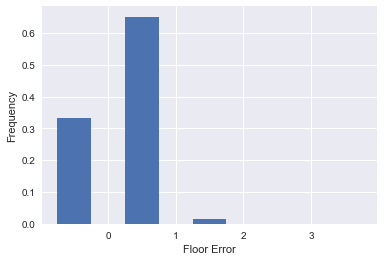

In [474]:
results['errors'] = abs(results.pred_delta) - abs(results.real_delta)
x = results.errors.values

# predicted in out
plt.figure(figsize=(6, 4))
fig, ax = plt.subplots() 
plt.ylabel('Frequency')
plt.xlabel('Floor Error')
plt.hist(x, bins=range(-1, 5), normed=True, rwidth=0.5)
savefig('./images/floor_err.png', bbox_inches='tight')
plt.show()

In [475]:
def plot_err_dists(flr_delta=False):
    bldgs = ['mudd', 'gsb', 'noco', 'ssw', 'rock']
    
    # measure errors across flr height ranges
    accs = []
    
    # create evenly spaced line of floats
    intervals = np.linspace(start=2.4, stop=5.0, num=11)
    print(intervals)
    results_mtx = np.zeros(shape=(len(bldgs), len(intervals)))
    
    for i, bldg in enumerate(bldgs):
        bldg_df, frames_names = load_data(bldg) 
    
        for j in range(len(intervals)):

            height = intervals[j]
            results, flr_heights = run(bldg_df,frames_names,  height)
            if flr_delta:
                results['errors'] = abs(results.pred_delta) - abs(results.real_delta)
            else:
                results['errors'] = abs(results.predicted) - abs(results.test_end)
            
            counts = results['errors'].value_counts()
            errs = counts.to_dict()
            acc = 0 
            if 0 in errs:
                acc = (float(errs[0])/len(results))
            results_mtx[i][j] = acc

    return results_mtx, intervals

#accs, intervals = plot_err_dists()
accs, intervals = plot_err_dists(flr_delta=True)

[ 2.4   2.66  2.92  3.18  3.44  3.7   3.96  4.22  4.48  4.74  5.  ]
avg acc RF:  0.959
avg acc SVM:  0.947
avg acc LG:  0.568


/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/s

avg acc HMM:  0.635
avg acc NN:  0.943
avg acc NN:  0.943
['mudd', 'a', '4', '11.csv']
['mudd', 'b', '4', '11.csv']
['mudd', 'c', '4', '11.csv']
['mudd', 'd', '4', '11.csv']
['mudd', 'e', '4', '11.csv']
['mudd', 'f', '4', '11.csv']
['mudd', 'g', '4', '11.csv']
['mudd', 'h', '4', '11.csv']
['mudd', 'i', '4', '11.csv']
['mudd', 'j', '4', '11.csv']
['mudd', 'a', '4', '11.csv']
['mudd', 'b', '4', '11.csv']
['mudd', 'c', '4', '11.csv']
['mudd', 'd', '4', '11.csv']
['mudd', 'e', '4', '11.csv']
['mudd', 'f', '4', '11.csv']
['mudd', 'g', '4', '11.csv']
['mudd', 'h', '4', '11.csv']
['mudd', 'i', '4', '11.csv']
['mudd', 'j', '4', '11.csv']
['mudd', 'a', '4', '11.csv']
['mudd', 'b', '4', '11.csv']
['mudd', 'c', '4', '11.csv']
['mudd', 'd', '4', '11.csv']
['mudd', 'e', '4', '11.csv']
['mudd', 'f', '4', '11.csv']
['mudd', 'g', '4', '11.csv']
['mudd', 'h', '4', '11.csv']
['mudd', 'i', '4', '11.csv']
['mudd', 'j', '4', '11.csv']
['mudd', 'a', '4', '11.csv']
['mudd', 'b', '4', '11.csv']
['mudd', 'c', 

/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/s

avg acc NN:  0.877
avg acc NN:  0.878
['gsb', 'a', '1', '3.csv']
['gsb', 'b', '1', '8.csv']
['gsb', 'c', '1', '3.csv']
['gsb', 'e', '1', '8.csv']
['gsb', 'f', '1', '8.csv']
['gsb', 'g', '1', '8.csv']
['gsb', 'h', '1', '3.csv']
['gsb', 'i', '1', '3.csv']
['gsb', 'j', '1', '3.csv']
['gsb', 'k', '1', '3.csv']
['gsb', 'l', '1', '3.csv']
['gsb', 'm', '1', '3.csv']
['gsb', 'n', '1', '3.csv']
['gsb', 'o', '1', '3.csv']
['gsb', 'a', '1', '3.csv']
['gsb', 'b', '1', '8.csv']
['gsb', 'c', '1', '3.csv']
['gsb', 'e', '1', '8.csv']
['gsb', 'f', '1', '8.csv']
['gsb', 'g', '1', '8.csv']
['gsb', 'h', '1', '3.csv']
['gsb', 'i', '1', '3.csv']
['gsb', 'j', '1', '3.csv']
['gsb', 'k', '1', '3.csv']
['gsb', 'l', '1', '3.csv']
['gsb', 'm', '1', '3.csv']
['gsb', 'n', '1', '3.csv']
['gsb', 'o', '1', '3.csv']
['gsb', 'a', '1', '3.csv']
['gsb', 'b', '1', '8.csv']
['gsb', 'c', '1', '3.csv']
['gsb', 'e', '1', '8.csv']
['gsb', 'f', '1', '8.csv']
['gsb', 'g', '1', '8.csv']
['gsb', 'h', '1', '3.csv']
['gsb', 'i', '1',

/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/s

avg acc NN:  0.934
avg acc NN:  0.934
['noco', 'a', '1', '10.csv']
['noco', 'b', '1', '10.csv']
['noco', 'c', '1', '10.csv']
['noco', 'd', '1', '10.csv']
['noco', 'e', '1', '10.csv']
['noco', 'f', '1', '10.csv']
['noco', 'g', '1', '10.csv']
['noco', 'h', '1', '10.csv']
['noco', 'i', '1', '10.csv']
['noco', 'j', '1', '10.csv']
['noco', 'a', '1', '10.csv']
['noco', 'b', '1', '10.csv']
['noco', 'c', '1', '10.csv']
['noco', 'd', '1', '10.csv']
['noco', 'e', '1', '10.csv']
['noco', 'f', '1', '10.csv']
['noco', 'g', '1', '10.csv']
['noco', 'h', '1', '10.csv']
['noco', 'i', '1', '10.csv']
['noco', 'j', '1', '10.csv']
['noco', 'a', '1', '10.csv']
['noco', 'b', '1', '10.csv']
['noco', 'c', '1', '10.csv']
['noco', 'd', '1', '10.csv']
['noco', 'e', '1', '10.csv']
['noco', 'f', '1', '10.csv']
['noco', 'g', '1', '10.csv']
['noco', 'h', '1', '10.csv']
['noco', 'i', '1', '10.csv']
['noco', 'j', '1', '10.csv']
['noco', 'a', '1', '10.csv']
['noco', 'b', '1', '10.csv']
['noco', 'c', '1', '10.csv']
['noc

/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/s

avg acc NN:  0.883
avg acc NN:  0.884
['ssw', 'a', '1', '11.csv']
['ssw', 'a', '1', '5.csv']
['ssw', 'b', '1', '11.csv']
['ssw', 'b', '1', '5.csv']
['ssw', 'c', '1', '11.csv']
['ssw', 'c', '1', '5.csv']
['ssw', 'd', '1', '11.csv']
['ssw', 'd', '1', '5.csv']
['ssw', 'e', '1', '11.csv']
['ssw', 'e', '1', '5.csv']
['ssw', 'f', '1', '11.csv']
['ssw', 'f', '1', '5.csv']
['ssw', 'g', '1', '11.csv']
['ssw', 'g', '1', '5.csv']
['ssw', 'h', '1', '11.csv']
['ssw', 'h', '1', '5.csv']
['ssw', 'i', '1', '11.csv']
['ssw', 'i', '1', '5.csv']
['ssw', 'j', '1', '11.csv']
['ssw', 'j', '1', '5.csv']
['ssw', 'a', '1', '11.csv']
['ssw', 'a', '1', '5.csv']
['ssw', 'b', '1', '11.csv']
['ssw', 'b', '1', '5.csv']
['ssw', 'c', '1', '11.csv']
['ssw', 'c', '1', '5.csv']
['ssw', 'd', '1', '11.csv']
['ssw', 'd', '1', '5.csv']
['ssw', 'e', '1', '11.csv']
['ssw', 'e', '1', '5.csv']
['ssw', 'f', '1', '11.csv']
['ssw', 'f', '1', '5.csv']
['ssw', 'g', '1', '11.csv']
['ssw', 'g', '1', '5.csv']
['ssw', 'h', '1', '11.csv']

/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/s

avg acc NN:  0.893
avg acc NN:  0.889
['rock', 'a', '1', '10.csv']
['rock', 'b', '1', '10.csv']
['rock', 'c', '1', '10.csv']
['rock', 'e', '1', '10.csv']
['rock', 'f', '1', '10.csv']
['rock', 'g', '1', '10.csv']
['rock', 'h', '1', '10.csv']
['rock', 'i', '1', '10.csv']
['rock', 'j', '1', '10.csv']
['rock', 'a', '1', '10.csv']
['rock', 'b', '1', '10.csv']
['rock', 'c', '1', '10.csv']
['rock', 'e', '1', '10.csv']
['rock', 'f', '1', '10.csv']
['rock', 'g', '1', '10.csv']
['rock', 'h', '1', '10.csv']
['rock', 'i', '1', '10.csv']
['rock', 'j', '1', '10.csv']
['rock', 'a', '1', '10.csv']
['rock', 'b', '1', '10.csv']
['rock', 'c', '1', '10.csv']
['rock', 'e', '1', '10.csv']
['rock', 'f', '1', '10.csv']
['rock', 'g', '1', '10.csv']
['rock', 'h', '1', '10.csv']
['rock', 'i', '1', '10.csv']
['rock', 'j', '1', '10.csv']
['rock', 'a', '1', '10.csv']
['rock', 'b', '1', '10.csv']
['rock', 'c', '1', '10.csv']
['rock', 'e', '1', '10.csv']
['rock', 'f', '1', '10.csv']
['rock', 'g', '1', '10.csv']
['roc

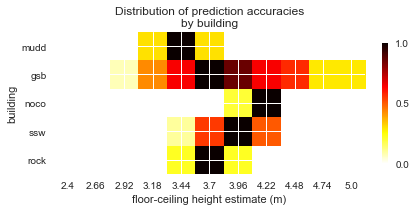

In [476]:
accs.shape
plt.imshow(accs, cmap='hot_r', interpolation='nearest')
plt.xticks(np.linspace(0, 10, 11), intervals)
plt.yticks([0,1,2,3, 4], ['mudd', 'gsb', 'noco', 'ssw', 'rock'])
plt.ylabel('building')
plt.xlabel('floor-ceiling height estimate (m)')
plt.colorbar(ticks=[0, 0.5, 1.00], orientation='vertical', fraction=0.018)
plt.title('Distribution of prediction accuracies\nby building')
savefig('./images/heat.png', bbox_inches='tight')
plt.show()

In [477]:
counts = results['errors'].value_counts()
print(counts)
print('\npercents\n', counts/len(x))

 0    41
-1    21
 1     1
Name: errors, dtype: int64

percents
  0    0.650794
-1    0.333333
 1    0.015873
Name: errors, dtype: float64


### Run test on cluster dataset

In [482]:
focus_exp_name = ''
frames, frames_names = load_data(focus_exp_name, data_path='/Users/waf/Developer/temp_floor/floor/data/floor_cluster_test_data/data')                      
#print('num experiments: ', len(frames))

meters = run_flr_find(frames,frames_names).values.flatten()

avg acc RF:  0.621
avg acc SVM:  0.758
avg acc LG:  0.786
avg acc HMM:  0.679


/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/waf/anaconda/envs/analysis/lib/python3.4/s

avg acc NN:  0.853
avg acc NN:  0.855


[4.9163581299180628, 5.0899290998170157, 5.1607004588218928, 5.1654731206702582, 5.2010888094815986, 5.4777927984459573, 5.5142313144281445, 8.0881565135596194, 8.3245789682248787, 8.5331855426000285, 8.5954104544104997, 8.7444250683283045, 9.1085316668565568, 9.121379632060961, 9.4352510342198652, 11.249021764177281, 11.396249023417376, 11.543346969676362, 12.058258594951244, 12.061291991838658, 12.146253549591631, 12.288216355478191, 12.373097739447857, 12.677457298495721, 15.259289845120772, 15.379644990300175, 15.635297526983468, 15.840511350564716, 18.559605939078164, 18.748893229370708, 18.749065225281658, 19.029525062216369, 19.304226535053218, 19.343848039306597, 22.386234310046195, 22.400741033274034, 22.75460898955016, 25.557456527866648, 25.872109042900171, 25.9837806758871, 26.153266237080395] 

predicted floor height =  nan
predicted floor height =  nan
predicted floor height =  nan
predicted floor height =  nan
predicted floor height =  nan
predicted floor height =  nan
p

/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


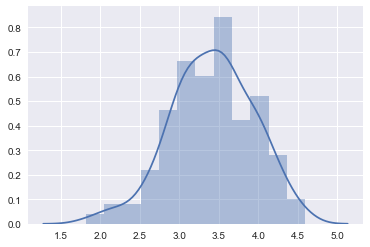

In [484]:
# sort meter changes 
meters = sorted(meters)
print(meters, '\n')

# list of heights as n goes to inf
pred_heights = []


for j in range(1, len(meters)):
    local_meters = meters[0:j]
    
    # cluster by taking items with < 1.5 meter difference
    clusters = []
    active_cluster = []
    active_m = local_meters[0]
    for m in local_meters:
        diff = abs(m - active_m)
        if diff <= 1.7:
            # in same cluster
            active_cluster.append(m)
        else:
            clusters.append(active_cluster)
            active_cluster = [m]
            active_m = m

    clusters.append(active_cluster)

            

    # try diff bn clusters
    diffs_clusters = []
    for i in range(len(clusters) - 1):
        cluster_a = clusters[i]
        cluster_b = clusters[i+1]
        diffs_clusters.append(abs(np.median(cluster_a) - np.median(cluster_b)))

    pred_height = np.mean(diffs_clusters)
    pred_heights.append(pred_height)
    print('predicted floor height = ', pred_height)
    
# try diff bn each measurement
msrs = []
for i in range(len(clusters) - 1):
    c_a = clusters[i]
    c_b = clusters[i+1]

    for a in c_a:
        for b in c_b:
            diff = abs(a - b)
            msrs.append(diff)
print(np.mean(msrs), np.median(msrs))
sns.distplot(msrs)



In [485]:
# estimated
est = []
pred_heights = []

# real 
real_h = [5.461, 3.6576, 3.6576, 3.5, 3.5, 3.5, 3.5, 3.5]
z = abs(np.median(clusters[0]))
est.append(z)
print('1 - 2', z, 'real: ', real_h[0])
for i in range(len(clusters)-1):
    z = abs(np.median(clusters[i]) - np.median(clusters[i + 1]))
    est.append(z)
    print(i + 2,'-', i + 3, z, 'real: ', real_h[i+1])
    pred_heights.append(np.mean(est))

print('est: ', np.mean(est))


1 - 2 5.16547312067 real:  5.461
2 - 3 3.5044446407 real:  3.6576
3 - 4 3.39137423047 real:  3.6576
4 - 5 3.4461792668 real:  3.5
5 - 6 3.38182388511 real:  3.5
6 - 7 3.51144588953 real:  3.5
7 - 8 3.47136800963 real:  3.5
est:  3.69601557756


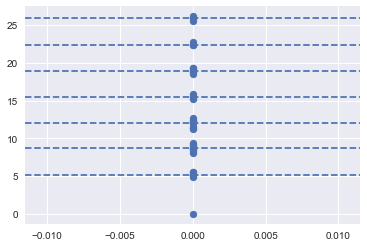

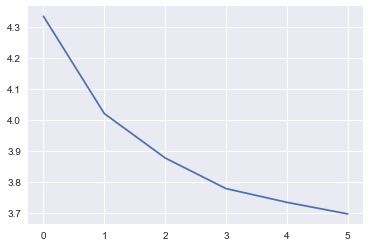

In [486]:
# plot predicted meter changes for each floor
ff = pd.DataFrame([0] + meters)
plt1 = plt.figure()
ax1 = plt1.add_subplot(111)
ax1.scatter(x=[0] * len(ff), y=ff)
for i in range(1, len(est)):
    ax1.axhline(sum(est[:i]), linestyle='--')

ax1.axhline(sum(est), label='Floor', linestyle='--')

plt2 = plt.figure()
ax2 = plt2.add_subplot(111)
ax2.plot(pred_heights)

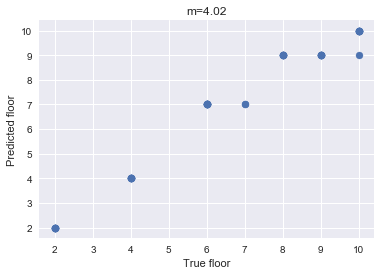

In [487]:
x = results.pred_delta.values.astype(np.float16)
# x += np.random.rand(len(x))
y = results.real_delta.values.astype(np.float16)
# y += np.random.rand(len(y))

# predicted in out
plt.figure(figsize=(6, 4))
fig, ax = plt.subplots() 
plt.ylabel('Predicted floor')
plt.xlabel('True floor')
plt.title('m=4.02')
plt.scatter(x, y)
savefig('./images/floor_scatter.png', bbox_inches='tight')
plt.show()

--- 
# Look at building data distribution   
This is how we learned the heuristic m=4.02 for office buildings   


### Residential buildings  

In [490]:
# plot distribution of heights
d = pd.read_json('../data/building_floor_distribution_data/buildings.json')
print(len(d))
bldgs = d[['height_architecture', 'floors_above','functions']]
office_bldgs = bldgs[bldgs.functions == 'office']
resi_bldgs = bldgs[bldgs.functions == 'residential']

bldgs = resi_bldgs
bldgs = bldgs.convert_objects(convert_numeric=True).dropna()

bldgs['flr_height'] = bldgs['height_architecture'] / bldgs['floors_above']

1343


/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/ipykernel/__main__.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [491]:
bldgs['flr_height'].describe()

count    615.000000
mean       3.325136
std        0.359867
min        2.522414
25%        3.087741
50%        3.240741
75%        3.486272
max        5.005882
Name: flr_height, dtype: float64

In [492]:
bldgs['flr_height'].median()

3.240740740740741

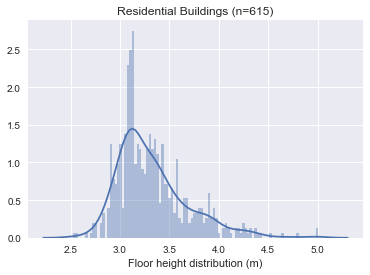

In [493]:
# bldgs['flr_height'].plot.density()
ax= sns.distplot(bldgs['flr_height'], bins=100)
ax.set(xlabel='Floor height distribution (m)')
ax.set(title='Residential Buildings (n={})'.format(len(bldgs)))
savefig('./images/res_bldg.png', bbox_inches='tight')

--- 
### Office buildings   
Look at building data distribution

In [494]:
# plot distribution of heights
d = pd.read_json('../data/building_floor_distribution_data/buildings.json')
print(len(d))
bldgs = d[['height_architecture', 'floors_above','functions']]
office_bldgs = bldgs[bldgs.functions == 'office']

bldgs = office_bldgs
bldgs = bldgs.convert_objects(convert_numeric=True).dropna()

bldgs['flr_height'] = bldgs['height_architecture'] / bldgs['floors_above']

1343


/Users/waf/anaconda/envs/analysis/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [495]:
bldgs['flr_height'].describe()

count    492.000000
mean       4.113913
std        0.473997
min        3.175000
25%        3.786538
50%        4.023619
75%        4.328398
max        6.650909
Name: flr_height, dtype: float64

In [496]:
bldgs['flr_height'].median()

4.023619152250761

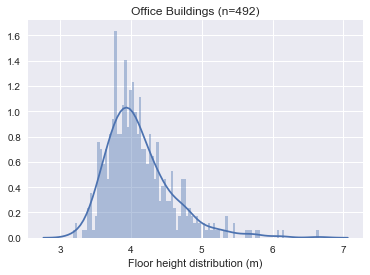

In [497]:
# bldgs['flr_height'].plot.density()
ax= sns.distplot(bldgs['flr_height'], bins=100)
ax.set(xlabel='Floor height distribution (m)')
ax.set(title='Office Buildings (n={})'.format(len(bldgs)))
savefig('./images/office_bldg.png', bbox_inches='tight')